# Day27 과제
논문의 Guidline에 따라서 코드 수정
- Generator 부분에서 LeakyRelu -> 'Relu' 로 변경
- Discriminator 부분에서 padding='same'
- Discriminator 부분에서 Flatten -> 'Global Average Pooling'으로 변경 (결과적으로 parameter수가 줄어든다.)
- discriminator.compile 부분에서 Adam의 lr='0.0002'로 변경
- gan_model.compile 부분에서 Adam의 lr은 논문마다 다르다.
  (같게  해줘도 무관.) 그러므로 discriminator.compile과 동일하게 해주자.

- Discriminator loss 에서
d_loss_batch = (d_loss_real[0] + d_loss_fake[0])




In [0]:
# 구글 드라이브와 연동하는 방법 입니다. 
# Google File Drive Stream 접근을 허용해야 합니다.
from google.colab import auth
auth.authenticate_user()

# 구글 드라이브 mount 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd gdrive/My Drive/datasets/DCGAN

/content/gdrive/My Drive/datasets/DCGAN


In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD
from keras import initializers
import os
import keras
from keras import layers
import matplotlib.pyplot as plt
import sys
import numpy as np
from keras.preprocessing import image

In [0]:
(X_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
X_train = X_train[y_train.flatten() == 2]

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
# figure를 plt로 visualize
def visualize_rgb(img):
    """
    Visualize a rgb image
    :param img: RGB image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")
    plt.show()

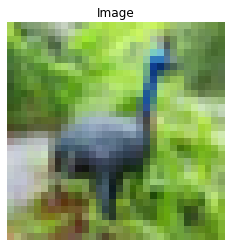

In [0]:
visualize_rgb(X_train[0])

In [0]:
# Input shape
img_rows = 32
img_cols = 32
channels = 3
        
img_shape = (img_rows, img_cols, channels)        
latent_dim = 100  

In [0]:
# latent space dimension
latent_dim = 100

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 2x2x512
generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((2, 2, 512)))
generator.add(BatchNormalization())
generator.add(ReLU(0.2)) # G 이므로 relu로 변경

# # Conv 1: 4x4x256
generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(ReLU(0.2))

# Conv 2: 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(ReLU(0.2))

# Conv 3: 16x16x64
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(ReLU(0.2))

# Conv 4: 32x32x3
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
                              activation='tanh'))

In [0]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_3 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 4, 4, 256)        

In [0]:
# imagem shape 32x32x3
img_shape = X_train[0].shape

# Discriminator network
discriminator = Sequential()

# Conv 1: 16x16x64
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# FC (X), Global Average Pooling (O)
# discriminator.add(Flatten())
discriminator.add(GlobalAveragePooling2D())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

In [0]:
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
batch_normalization_17 (Batc (None, 4, 4, 256)        

In [0]:
# Optimizer
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# d_g = discriminador(generador(z))
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
gan_model = Model(inputs=z, outputs=decision)

gan_model.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [0]:
def normalize(img):
    return (img - 127.5) / 127.5

In [0]:
def denormalize(img):
    img = (img * 127.5) + 127.5
    return img.astype(np.uint8)

In [0]:
print(X_train.shape)

(5000, 32, 32, 3)


In [0]:
# 데이터를 정규화합니다
X_train = normalize(X_train)

iterations = 5000
batch_size = 20
save_dir = os.path.join("./", 'gan_images')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [0]:
epochs = 100
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = gan_model.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 3 == 0:
      # 모델 가중치를 저장합니다
      gan_model.save_weights('gan.h5')

      # 생성된 이미지 하나를 저장합니다
      img = image.array_to_img(denormalize(X_fake[0]), scale=False)
      img.save(os.path.join(save_dir, 'generated' + str(e) + '.png'))
      # 비교를 위해 진짜 이미지 하나를 저장합니다
      img = image.array_to_img(denormalize(X_batch[0]), scale=False)
      img.save(os.path.join(save_dir, 'real' + str(e) + '.png'))
       



epoch = 1/100, d_loss=0.378, g_loss=3.096                                                                                                     
epoch = 2/100, d_loss=0.349, g_loss=3.802                                                                                                     
epoch = 3/100, d_loss=0.346, g_loss=3.982                                                                                                     
epoch = 4/100, d_loss=0.337, g_loss=4.465                                                                                                     
epoch = 5/100, d_loss=0.334, g_loss=4.770                                                                                                     
epoch = 6/100, d_loss=0.333, g_loss=4.993                                                                                                     
epoch = 7/100, d_loss=0.331, g_loss=5.324                                                                                                   